In [10]:
from pathlib import Path
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.layers import BatchNormalization, Dense, Input, Conv1D, Add, ELU, Flatten, MaxPooling1D
from keras.layers import GlobalAveragePooling1D, Softmax, Concatenate, Reshape, Multiply, ReLU
from keras.optimizers import SGD
from keras import activations
from keras import Model
from keras.initializers import HeNormal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from load_dataset import load_original_daic, load_labels
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.vis_utils import plot_model
import keras_dilated_nn

In [11]:
daic_pose_train = load_original_daic("original_daic/train", "pose")
daic_pose_dev = load_original_daic("original_daic/dev", "pose")
daic_pose_test = load_original_daic("original_daic/test", "pose")

daic_lm_train = load_original_daic("original_daic/train", "features")
daic_lm_dev = load_original_daic("original_daic/dev", "features")
daic_lm_test = load_original_daic("original_daic/test", "features")

In [12]:
label_path = Path("original_daic/labels")
loaded_labels = load_labels(label_path)
y_train = np.array(loaded_labels["train"])
y_dev = np.array(loaded_labels["dev"])
y_test = np.array(loaded_labels["test"])

In [13]:
pose_train = []
pose_dev = []
pose_test = []
for subject_id, subject_df in daic_pose_train.items():
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    pose_train.append(temp)
for subject_id, subject_df in daic_pose_dev.items():
    # print(subject_id)
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    pose_dev.append(temp)
for subject_id, subject_df in daic_pose_test.items():
    # print(subject_id)
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    pose_test.append(temp)

In [14]:
lm_train = []
lm_dev = []
lm_test = []
for subject_id, subject_df in daic_lm_train.items():
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    lm_train.append(temp)
for subject_id, subject_df in daic_lm_dev.items():
    # print(subject_id)
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    lm_dev.append(temp)
for subject_id, subject_df in daic_lm_test.items():
    # print(subject_id)
    temp = subject_df.copy().loc[1000:5999].to_numpy(dtype="float32")
    lm_test.append(temp)

In [15]:
all_pose_samples = pose_train + pose_dev + pose_test
# all_samples = np.array(pose_train + pose_dev + pose_test, dtype=object)
all_pose_samples = np.concatenate((all_pose_samples),)
# all_samples.shape
pose_min_values = all_pose_samples.min(axis=0)
pose_ptp_ranges = all_pose_samples.ptp(axis=0)

all_lm_samples = lm_train + lm_dev + lm_test
# all_samples = np.array(pose_train + pose_dev + pose_test, dtype=object)
all_lm_samples = np.concatenate((all_lm_samples),)
# all_samples.shape
lm_min_values = all_lm_samples.min(axis=0)
lm_ptp_ranges = all_lm_samples.ptp(axis=0)

In [16]:
pose_train = np.array(pose_train)
pose_dev = np.array(pose_dev)
pose_test = np.array(pose_test)

lm_train = np.array(lm_train)
lm_dev = np.array(lm_dev)
lm_test = np.array(lm_test)

In [17]:
norm_pose_train = (pose_train - pose_min_values)/pose_ptp_ranges
norm_pose_dev = (pose_dev - pose_min_values)/pose_ptp_ranges
norm_pose_test = (pose_test - pose_min_values)/pose_ptp_ranges

norm_lm_train = (lm_train - lm_min_values)/lm_ptp_ranges
norm_lm_dev = (lm_dev - lm_min_values)/lm_ptp_ranges
norm_lm_test = (lm_test - lm_min_values)/lm_ptp_ranges

In [18]:
# depressed_only = norm_pose_train[train_depressed_idx]
indices = range(norm_pose_train.shape[0])
oversample = RandomOverSampler(sampling_strategy='minority')
# oversample = RandomOverSampler(sampling_strategy=0.75)
# print(norm_pose_train[:].shape)
indices = np.array(indices).reshape(-1,1)
ros_indices, over_train_y = oversample.fit_resample(indices, y_train)
print(len(ros_indices))
ros_norm_pose_train = np.squeeze(norm_pose_train[ros_indices])
ros_norm_lm_train = np.squeeze(norm_lm_train[ros_indices])
# print(ros_norm_pose_train.shape)

154


In [28]:
del daic_lm_dev, daic_lm_test, daic_lm_train, daic_pose_dev, daic_pose_test, daic_pose_train
del pose_train, pose_dev, pose_test, lm_train, lm_dev, lm_test
del all_pose_samples, all_lm_samples

In [19]:
input_pose = Input(shape=[5000, 6])
tdcn_dim_pose = [128,64,256,128,64] # used in Guo's paper
# tdcn_dim_pose = [128,128,128,128,128]
input_lm = Input(shape=[5000, 136])
tdcn_dim_lm = [256,256,128,64,64] # used in Guo's paper
# tdcn_dim_lm = [256,256,256,256,256]
bias_initializer = HeNormal(seed=0)

In [20]:
# x_train_bad = np.concatenate((np.zeros((200, 5000, 6)), np.ones((200, 5000, 6))))
# y_train_bad = np.concatenate((np.zeros(200), np.ones(200)))
# x_dev_bad = np.concatenate((np.zeros((20, 5000, 6)), np.ones((20, 5000, 6))))
# y_dev_bad = np.concatenate((np.zeros(20), np.ones(20)))
# print(x_train_bad.shape)
# print(y_train_bad.shape)

In [30]:
# TDCN block for pose
tdcn_pose = keras_dilated_nn.time_diluted_conv_net(
    feature_dim = tdcn_dim_pose, 
    input_layer = input_pose, 
    pool_size = 2, 
    pool_stride = 2,
    )

# TDCN block for landmarks
tdcn_lm = keras_dilated_nn.time_diluted_conv_net(
    feature_dim = tdcn_dim_lm, 
    input_layer = input_lm, 
    pool_size = 2, 
    pool_stride = 2,
    )

# FWA block
concat_layer = Concatenate()([tdcn_pose, tdcn_lm])
# print(concat_layer.shape)
gap_layer = GlobalAveragePooling1D(data_format="channels_last")(concat_layer)
# print(gap_layer.shape)

linear_layer_1 = Dense(gap_layer.shape[1])(gap_layer)
relu_layer = activations.relu(linear_layer_1)
linear_layer_2 = Dense(gap_layer.shape[1])(relu_layer)
sigmoid_layer = activations.sigmoid(linear_layer_2)
elementwise_product = Multiply()([concat_layer, sigmoid_layer])
print(elementwise_product.shape)
# FC layer
flatten = Flatten()(elementwise_product)
print(flatten.shape)
# FC_l1 = Dense(300, activation="relu")(flatten)
# FC_l2 = Dense(300, activation="relu")(FC_l1)
# FC_l3 = Dense(100, activation="relu")(FC_l2)
FC_l1 = Dense(32, activation="relu")(flatten)
FC_l2 = Dense(16, activation="relu")(FC_l1)
FC_l3 = Dense(8, activation="relu")(FC_l2)
last_layer = Dense(2, activation="relu")(FC_l3)
output = Softmax()(last_layer)
# output = Dense(1, activation = "sigmoid")(FC_l3)

(None, 312, 128)
(None, 39936)


In [23]:
batch_size = 8
checkpoint_path = "training_ckpts/pose_training_C2-{epoch:04d}.ckpt"
checkpoint_dir = Path(checkpoint_path)

cp_callback = ModelCheckpoint(filepath=checkpoint_dir, save_weights_only=True, save_freq=5*batch_size, verbose=1)

In [31]:
model_pose_lm = Model(inputs=[input_pose, input_lm], outputs=[output])

In [25]:
# model_pose_lm = load_model()

In [32]:
opt = SGD(learning_rate = 2e-5, momentum = 0.9)
model_pose_lm.compile(loss = "binary_crossentropy", optimizer=opt, metrics=['accuracy'])
# model_pose_lm.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [33]:
# model_pose.fit(x_train_bad[:], y_train_bad[:], validation_data=(x_dev_bad[:], y_dev_bad[:]), epochs=2)
# model_pose_lm.fit([norm_pose_train[:], norm_lm_train[:]], y_train[:], validation_data=([norm_pose_dev[:], norm_lm_dev[:]], y_dev[:]), epochs=6, batch_size=8)
model_pose_lm.fit([ros_norm_pose_train[:], ros_norm_lm_train[:]], over_train_y[:], validation_data=([norm_pose_dev[:], norm_lm_dev[:]], y_dev[:]), epochs=6, batch_size=8)

Epoch 1/6
20/20 [==============================] - 83s 4s/step - loss: 0.7514 - accuracy: 0.4740 - val_loss: 0.6974 - val_accuracy: 0.6571
Epoch 2/6
20/20 [==============================] - 82s 4s/step - loss: 0.6963 - accuracy: 0.5000 - val_loss: 0.6951 - val_accuracy: 0.6571
Epoch 3/6
20/20 [==============================] - 80s 4s/step - loss: 0.6948 - accuracy: 0.5065 - val_loss: 0.6945 - val_accuracy: 0.6286
Epoch 4/6
20/20 [==============================] - 84s 4s/step - loss: 0.6947 - accuracy: 0.5195 - val_loss: 0.6944 - val_accuracy: 0.6571
Epoch 5/6
20/20 [==============================] - 81s 4s/step - loss: 0.6942 - accuracy: 0.5000 - val_loss: 0.6941 - val_accuracy: 0.6571
Epoch 6/6
20/20 [==============================] - 81s 4s/step - loss: 0.6939 - accuracy: 0.5000 - val_loss: 0.6937 - val_accuracy: 0.6571


In [ ]:
# model_pose.evaluate(x=pose_test, y=y_test)
print(sum(y_train)/len(y_train))
print(sum(y_dev)/len(y_dev))
print(sum(y_test)/len(y_test))

0.2803738317757009
0.34285714285714286
0.2978723404255319


4/4 [==============================] - 13s 3s/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[0.71962617 0.        ]
 [0.28037383 0.        ]]


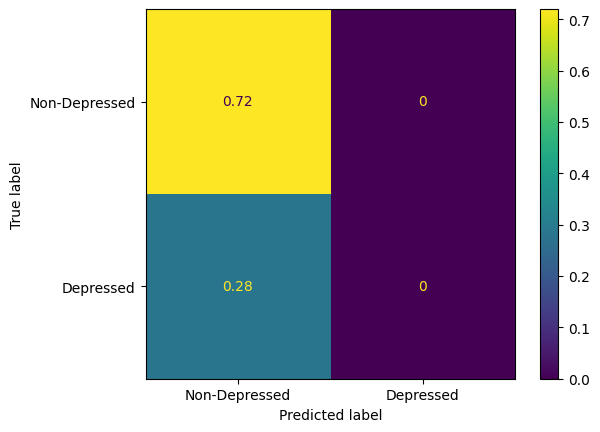

Accuracy = 0.719626168224299
Recall = 0.0
Precision = nan
F1-score = nan


C:\Users\u1737136\AppData\Local\Temp\ipykernel_14796\2753824314.py:23: RuntimeWarning: invalid value encountered in double_scalars
  precision = tp_pose / (tp_pose + fp_pose)


In [36]:
#Predict
# x = [norm_pose_dev, norm_lm_dev]
x = [norm_pose_train, norm_lm_train]
y = y_train
# x = x_dev_bad
# y = y_dev_bad
y_pose_lm_prediction = model_pose_lm.predict(x)
y_pose_lm_prediction = np.argmax(y_pose_lm_prediction, axis = 1)
# print(sum(y_pose_prediction)/len(y_pose_prediction))
print(y_pose_lm_prediction)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y, y_pose_lm_prediction, normalize='pred')
print(result)
cm_display = ConfusionMatrixDisplay(confusion_matrix = result, display_labels = ["Non-Depressed", "Depressed"])
cm_display.plot()
plt.show()
tn_pose = result[0][0]
tp_pose = result[1][1]
fn_pose = result[1][0]
fp_pose = result[0][1]
accuracy = (tp_pose + tn_pose)/(tp_pose + tn_pose + fp_pose + fn_pose)
recall = tp_pose / (tp_pose + fn_pose)
precision = tp_pose / (tp_pose + fp_pose)
f1_score = 2 * precision * recall / (precision + recall)
print("Accuracy = " + str(accuracy))
print("Recall = " + str(recall))
print("Precision = " + str(precision))
print("F1-score = " + str(f1_score))

In [ ]:
# plot_model(model_pose_lm, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

NameError: name 'model_pose' is not defined

In [ ]:
# model_pose.save("saved_models/good_pose_21_6")

INFO:tensorflow:Assets written to: saved_models/good_pose_21_6\assets


INFO:tensorflow:Assets written to: saved_models/good_pose_21_6\assets
